# Sistem Rekomendasi: Rekomendasi Anime Berdasarkan Model Content-based Filtering


*Oleh : Ghifari Ismail*

*Proyek Submission 2 - Machine Learning Terapan Dicoding*

## 1. Mempersiapkan dataset

### 1.1 Menyiapkan kredensial akun Kaggle

In [1]:
# Install library kaggle
! pip install kaggle 

In [2]:
# Membuat direktori dengan nama ".kaggle"
! mkdir ~/.kaggle

In [3]:
# Copy "kaggle.json" ke dalam direktori yang telah dibuat
! cp kaggle.json ~/.kaggle/

In [4]:
# Mengalokasikan izin yang diperlukan untuk file tersebut
! chmod 600 ~/.kaggle/kaggle.json

### 1.2 Mengunduh dan menyiapkan dataset

![SS](https://github.com/GhifSmile/content_based_filtering/blob/main/Capture.PNG?raw=true)




| **Jenis** |   **Keterangan**   |
| --------- | --------------     |
|  Sumber   | [Anime Recommendations Database](https://www.kaggle.com/CooperUnion/anime-recommendations-database) |
| Lisensi   | CC0: Public Domain |
| Rating Penggunaan | 8.2 |
| Jenis dan Ukuran Berkas | CSV (112 MB) |

In [5]:
# Mengunduh dan menyiapkan dataset 
! kaggle datasets download CooperUnion/anime-recommendations-database

 84% 21.0M/25.0M [00:00<00:00, 37.6MB/s]
100% 25.0M/25.0M [00:00<00:00, 83.4MB/s]


In [6]:
# Mengekstrak zip file
import zipfile

local_zip = '/content/anime-recommendations-database.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

## 2. Data Understanding

### 2.1 Mengubah dataset menjadi dataframe dan melihat beberapa informasi yang ada

In [7]:
# Mengubah dataset menjadi dataframe
import pandas as pd

anim = pd.read_csv('/content/anime.csv')

anim

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


Deskripsi dari variabel-variabel yang ada pada Anime Recommendations Database adalah sebagai berikut:

- anime_id: myanimelist unik id yang mengidentifikasi sebuah anime
- nama: nama lengkap dari sebuah anime
- genre: genre dari sebuah anime
- type: tipe dari anime berdasarkan jenis anime
- episodes: banyak episode dari sebuah anime(1 jika merupakan sebuah movie)
- rating: rata-rata rating dari sebuah anime dengan skala sampai 10
- members: jumlah anggota dari komunitas pada sebuah anime


In [8]:
# Melihat informasi yang ada pada dataset
anim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [9]:
# Melihat ada tidaknya nilai yang hilang pada dataset
anim.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

### 2.2 Univariate Exploratory Data Analysis

In [10]:
# Mengetahui jumlah serta beberapa nilai yang unik pada variabel anime_id
print('Banyak anime id', len(anim.anime_id.unique()))
print('Anime id:', anim.anime_id.unique())

Banyak anime id 12294
Anime id: [32281  5114 28977 ...  5621  6133 26081]


In [11]:
# Mengetahui jumlah serta beberapa nilai yang unik pada variabel name
print('Banyak nama anime', len(anim.name.unique()))
print('Nama anime:', anim.name.unique())

Banyak nama anime 12292
Nama anime: ['Kimi no Na wa.' 'Fullmetal Alchemist: Brotherhood' 'Gintama°' ...
 'Violence Gekiga David no Hoshi'
 'Violence Gekiga Shin David no Hoshi: Inma Densetsu'
 'Yasuji no Pornorama: Yacchimae!!']


In [12]:
# Mengetahui jumlah serta beberapa nilai yang unik pada variabel genre
print('Banyak genres', len(anim.genre.unique()))
print('Genres', anim.genre.unique())

Banyak genres 3265
Genres ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Hentai, Sports' 'Drama, Romance, School, Yuri' 'Hentai, Slice of Life']


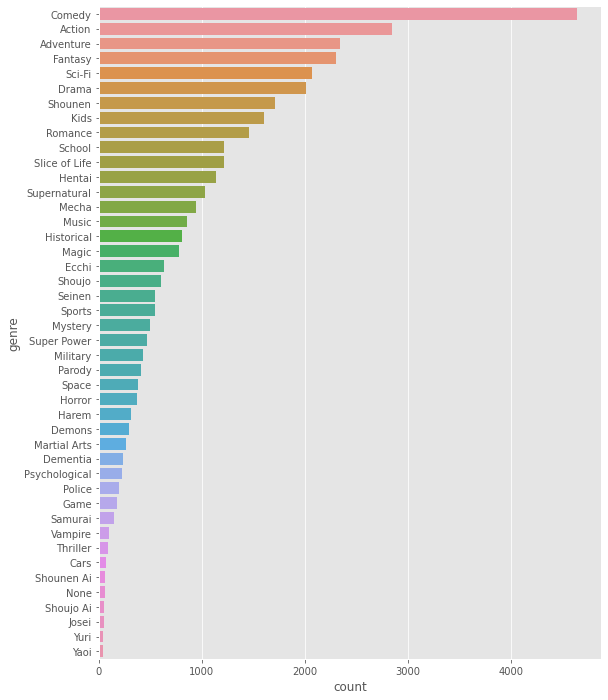

In [13]:
# Melakukan visualisasi pada variabel genre untuk mendapatkan informasi

import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import itertools
from collections import Counter 


anim.genre = anim.genre.fillna('None') # Mengisi nilai yang hilang pada variabel genre dengan None
genre_anime = anim.genre.apply(lambda x: x.split(', ')).values.tolist()
genre = itertools.chain(*genre_anime)
genre_count = Counter(genre)

genre_df = pd.DataFrame.from_dict(genre_count,orient='index').reset_index()
genre_df.columns = ["genre","count"]
genre_df = genre_df.sort_values('count', ascending=False)
plt.figure(figsize=(9,12))
sns.barplot(x=genre_df["count"], y=genre_df["genre"])

Dapat dilihat dari visualisasi bahwasanya jumlah genre anime comedy merupakan jumlah yang terbanyak dibanding dengan genre anime lainnya. Terlihat pula dalam visualisasi terdapat genre None yang nantinya akan didrop pada Data Preparation, karena genre tersebut hanya representasi nilai yang hilang pada genre.

In [14]:
# Mengetahui jumlah serta beberapa nilai yang unik pada variabel type
print('Banyak tipe', len(anim['type'].unique()))
print('tipe', anim['type'].unique())

Banyak tipe 7
tipe ['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA' nan]


In [15]:
# Mengetahui jumlah serta beberapa nilai yang unik pada variabel episodes
print('Banyak akumulasi episodes', len(anim.episodes.unique()))
print('episodes', anim.episodes.unique())

Banyak akumulasi episodes 187
episodes ['1' '64' '51' '24' '10' '148' '110' '13' '201' '25' '22' '75' '4' '26'
 '12' '27' '43' '74' '37' '2' '11' '99' 'Unknown' '39' '101' '47' '50'
 '62' '33' '112' '23' '3' '94' '6' '8' '14' '7' '40' '15' '203' '77' '291'
 '120' '102' '96' '38' '79' '175' '103' '70' '153' '45' '5' '21' '63' '52'
 '28' '145' '36' '69' '60' '178' '114' '35' '61' '34' '109' '20' '9' '49'
 '366' '97' '48' '78' '358' '155' '104' '113' '54' '167' '161' '42' '142'
 '31' '373' '220' '46' '195' '17' '1787' '73' '147' '127' '16' '19' '98'
 '150' '76' '53' '124' '29' '115' '224' '44' '58' '93' '154' '92' '67'
 '172' '86' '30' '276' '59' '72' '330' '41' '105' '128' '137' '56' '55'
 '65' '243' '193' '18' '191' '180' '91' '192' '66' '182' '32' '164' '100'
 '296' '694' '95' '68' '117' '151' '130' '87' '170' '119' '84' '108' '156'
 '140' '331' '305' '300' '510' '200' '88' '1471' '526' '143' '726' '136'
 '1818' '237' '1428' '365' '163' '283' '71' '260' '199' '225' '312' '240'
 '1306' 

In [16]:
# Mengetahui jumlah serta beberapa nilai yang unik pada variabel rating
print('Banyak akumulasi rating', len(anim.rating.unique()))
print('rating', anim.rating.unique())

Banyak akumulasi rating 599
rating [ 9.37  9.26  9.25  9.17  9.16  9.15  9.13  9.11  9.1   9.06  9.05  9.04
  8.98  8.93  8.92  8.88  8.84  8.83  8.82  8.81  8.8   8.78  8.77  8.76
  8.75  8.74  8.73  8.72  8.71  8.69  8.68  8.67  8.66  8.65  8.64  8.62
  8.61  8.6   8.59  8.58  8.57  8.56  8.55  8.54  8.53  8.52  8.51  8.5
  8.49  8.48  8.47  8.46  8.45  8.44  8.43  8.42  8.41  8.4   8.39  8.38
  8.37  8.36  8.35  8.34  8.33  8.32  8.31  8.3   8.29  8.28  8.27  8.26
  8.25  8.24  8.23  8.22  8.21  8.2   8.19  8.18  8.17  8.16  8.15  8.14
  8.13  8.12  8.11  8.1   8.09  8.08  8.07  8.06  8.05  8.04  8.03  8.02
  8.01  8.    7.99  7.98  7.97  7.96  7.95  7.94  7.93  7.92  7.91  7.9
  7.89  7.88  7.87  7.86  7.85  7.84  7.83  7.82  7.81  7.8   7.79  7.78
  7.77  7.76  7.75  7.74  7.73  7.72  7.71  7.7   7.69  7.68  7.67  7.66
  7.65  7.64  7.63  7.62  7.61  7.6   7.59  7.58  7.57  7.56  7.55  7.54
  7.53  7.52  7.51  7.5   7.49  7.48  7.47  7.46  7.45  7.44  7.43  7.42
  7.41  7.4   7.39

In [17]:
# Mengetahui jumlah serta beberapa nilai yang unik pada variabel members
print('Banyak akumulasi members', len(anim.members.unique()))
print('members', anim.members.unique())

Banyak akumulasi members 6706
members [200630 793665 114262 ...  27411  57355    652]


## 3. Data Preparation

### 3.1 Melakukan drop pada variabel yang tidak diperlukan untuk model

In [18]:
# Melihat jumlah tipe Music pada variabel type untuk didrop
msc = (anim['type']=='Music').sum()
# Melihat jumlah genre None pada variabel genre untuk didrop
genr = (anim['genre']=='None').sum()

print(msc)
print(genr)

488
62


Menghilangkan tipe Music pada variabel type diperlukan untuk relevansi pada kasus ini yang merupakan rekomendasi anime. 

In [19]:
# Memilih dataset dengan tidak menyertakan tipe Music pada variabel type dan genre None pada variabel genre
anim = anim.loc[(anim['type']!='Music')]
anim = anim.loc[(anim['genre']!='None')]
anim.shape

(11744, 7)

In [20]:
# Melakukan drop pada variabel yang tidak diperlukan untuk model
anim = anim.drop(columns=['episodes', 'members', 'type', 'rating'])

In [21]:
# Melihat lima sampel awal pada dataset
anim.head()

,anime_id,name,genre
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
3,9253,Steins;Gate,"Sci-Fi, Thriller"
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S..."


In [22]:
# Melakukan drop pada sampel dengan nilai yang hilang untuk antisipasi
anim_new = anim.dropna()

In [23]:
# Melihat ada tidaknya nilai yang hilang setelah melakukan drop
anim_new.isnull().sum()

anime_id    0
name        0
genre       0
dtype: int64

In [24]:
# Melihat dataset pada dataframe setelah memilah serta memilih variabel yang diperlukan untuk model
anim_new

,anime_id,name,genre
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
3,9253,Steins;Gate,"Sci-Fi, Thriller"
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S..."
...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai
12290,5543,Under World,Hentai
12291,5621,Violence Gekiga David no Hoshi,Hentai
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai


Setelah dilakukan beberapa tahap data preparation, kini jumlah sampel tersisa 11744 dari sebelumnya berjumlah 12294.

### 3.2 Melakukan sorting dataset dan drop duplikasi dataset berdasarkan variabel anime_id

In [25]:
# Melakukan sorting pada dataset berdasarkan anime_id
anim_new = anim_new.sort_values('anime_id', ascending=True)

In [26]:
# Melihat dataset pada dataframe setelah disorting
anim_new

,anime_id,name,genre
22,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
152,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space"
214,6,Trigun,"Action, Comedy, Sci-Fi"
2095,7,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna..."
3159,8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural"
...,...,...,...
2726,34514,Pokemon Generations,"Action, Adventure, Fantasy, Game, Kids"
9586,34519,Mobile Suit Gakuen: G-Reco Koushien,Comedy
11104,34522,"Wake Up, Girls! Shin Shou","Drama, Music"
10952,34525,Centaur no Nayami,"Comedy, Fantasy, Slice of Life, Supernatural"


In [27]:
# Melakukan drop duplikasi pada dataset berdasarkan anime_id
anim_new = anim_new.drop_duplicates('anime_id')
anim_new

,anime_id,name,genre
22,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
152,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space"
214,6,Trigun,"Action, Comedy, Sci-Fi"
2095,7,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna..."
3159,8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural"
...,...,...,...
2726,34514,Pokemon Generations,"Action, Adventure, Fantasy, Game, Kids"
9586,34519,Mobile Suit Gakuen: G-Reco Koushien,Comedy
11104,34522,"Wake Up, Girls! Shin Shou","Drama, Music"
10952,34525,Centaur no Nayami,"Comedy, Fantasy, Slice of Life, Supernatural"


### 3.3 Menerapkan teknik One Hot Encoding pada variabel genre untuk keperluan model

In [28]:
# Melakukan split pada variabel genre, kemudian dibentuk suatu list
anim_new['genre']=anim_new['genre'].str.split(',')
anim_new.head()

,anime_id,name,genre
22,1,Cowboy Bebop,"[Action, Adventure, Comedy, Drama, Sci-Fi,..."
152,5,Cowboy Bebop: Tengoku no Tobira,"[Action, Drama, Mystery, Sci-Fi, Space]"
214,6,Trigun,"[Action, Comedy, Sci-Fi]"
2095,7,Witch Hunter Robin,"[Action, Drama, Magic, Mystery, Police, S..."
3159,8,Beet the Vandel Buster,"[Adventure, Fantasy, Shounen, Supernatural]"


In [29]:
# Mengimplementasikan One Hot Encoding pada variabel genre
for index,row in anim_new.iterrows():
    for genres in row['genre']:
        anim_new.at[index,genres] = 1

In [30]:
# Mengisi nan pada kolom dengan 0
anim_new = anim_new.fillna(0)
anim_new.head()

,anime_id,name,genre,Action,Adventure,Comedy,Drama,Sci-Fi,Space,Mystery,Magic,Police,Supernatural,Adventure,Fantasy,Shounen,Sports,Comedy,Josei,Romance,Slice of Life,Cars,Seinen,Drama,Horror,Psychological,Thriller,Martial Arts,Super Power,School,Ecchi,Vampire,Historical,Military,Dementia,Mecha,Dementia,Demons,Samurai,Game,...,Shounen Ai,Kids,Historical,School,Hentai,Hentai,Parody,Horror,Demons,Ecchi,Fantasy,Shounen,Game,Yuri,Mystery,Cars,Magic,Romance,Sci-Fi,Harem,Yaoi,Kids,Shoujo,Military,Super Power,Martial Arts,Slice of Life,Music,Sports,Supernatural,Parody,Vampire,Psychological,Samurai,Yaoi,Seinen,Josei,Thriller,Police,Space
22,1,Cowboy Bebop,"[Action, Adventure, Comedy, Drama, Sci-Fi,...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152,5,Cowboy Bebop: Tengoku no Tobira,"[Action, Drama, Mystery, Sci-Fi, Space]",1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214,6,Trigun,"[Action, Comedy, Sci-Fi]",1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2095,7,Witch Hunter Robin,"[Action, Drama, Magic, Mystery, Police, S...",1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3159,8,Beet the Vandel Buster,"[Adventure, Fantasy, Shounen, Supernatural]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.4 Melakukan drop pada variabel yang tidak diperlukan untuk model

In [31]:
# Melakukan drop pada variabel anime_id dan genre
anim_new = anim_new.drop(columns=['anime_id', 'genre'])
anim_new

,name,Action,Adventure,Comedy,Drama,Sci-Fi,Space,Mystery,Magic,Police,Supernatural,Adventure,Fantasy,Shounen,Sports,Comedy,Josei,Romance,Slice of Life,Cars,Seinen,Drama,Horror,Psychological,Thriller,Martial Arts,Super Power,School,Ecchi,Vampire,Historical,Military,Dementia,Mecha,Dementia,Demons,Samurai,Game,Shoujo,Harem,...,Shounen Ai,Kids,Historical,School,Hentai,Hentai,Parody,Horror,Demons,Ecchi,Fantasy,Shounen,Game,Yuri,Mystery,Cars,Magic,Romance,Sci-Fi,Harem,Yaoi,Kids,Shoujo,Military,Super Power,Martial Arts,Slice of Life,Music,Sports,Supernatural,Parody,Vampire,Psychological,Samurai,Yaoi,Seinen,Josei,Thriller,Police,Space
22,Cowboy Bebop,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152,Cowboy Bebop: Tengoku no Tobira,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214,Trigun,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2095,Witch Hunter Robin,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3159,Beet the Vandel Buster,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,Pokemon Generations,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9586,Mobile Suit Gakuen: G-Reco Koushien,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11104,"Wake Up, Girls! Shin Shou",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10952,Centaur no Nayami,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## 4. Modeling

### 4.1 Mengambil nilai yang menjadi genre anime pada dataset

In [32]:
# Mengambil nilai yang menjadi genre anime pada dataset
gen = anim_new.iloc[:,1:].values
gen.shape

(11744, 82)

### 4.2 Menghitung derajat kesamaan antar anime dengan teknik cosine similarity

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
 
# Menghitung cosine similarity pada matrix gen
cosine_sim = cosine_similarity(gen) 
cosine_sim

array([[1.        , 0.73029674, 0.70710678, ..., 0.        , 0.        ,
        0.        ],
       [0.73029674, 1.        , 0.51639778, ..., 0.        , 0.        ,
        0.        ],
       [0.70710678, 0.51639778, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

### 4.3 Melihat matriks kesamaan setiap anime

In [34]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama anime
cosine_sim_df = pd.DataFrame(cosine_sim, index=anim_new['name'], columns=anim_new['name'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap anime dengan hanya menampilkan beberapa saja
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (11744, 11744)


name,47 Todoufuken,Teekyuu 5,Cinderella Boy,Kizuoibito,Persona 4 the Animation: The Factor of Hope
name,,,,,
Kouchuu Ouja Mushiking Super Battle Movie: Yami no Kaizou Kouchuu,0.000000,0.000000,0.000000,0.000000,0.316228
Pokemon Diamond &amp; Pearl: Arceus Choukoku no Jikuu e,0.288675,0.000000,0.612372,0.408248,0.000000
"Wake Up, Girl Zoo! Miyagi PR de Go!",0.707107,0.577350,0.000000,0.000000,0.000000
Shakugan no Shana Specials,0.500000,0.408248,0.000000,0.000000,0.000000
UFO Nitsukamatta Kodomo-tachi,0.000000,0.000000,0.000000,0.000000,0.000000
Himitsukessha Taka no Tsume NEO,0.408248,0.333333,0.000000,0.000000,0.258199
Mashin Eiyuuden Wataru,0.000000,0.258199,0.223607,0.000000,0.200000
Norakuro Nitouhei: Enshuu no Maki,0.000000,0.000000,0.000000,0.000000,0.447214
Hells,0.000000,0.000000,0.288675,0.000000,0.258199


### 4.4 Mendapatkan rekomendasi anime

#### 4.4.1 Membuat fungsi anime_recommendations

In [35]:
def anime_recommendations(nama_anime, similarity_data=cosine_sim_df, items=anim[['name', 'genre']], k=5):
    
    """
    Rekomendasi anime berdasarkan kemiripan dataframe
 
    Parameter:
    ---
    nama_anime : tipe data string (str)
                 Nama anime (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan name sebagai 
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---
 
 
    Pada index ini, kita mengambil k dengan nilai similarity terbesar 
    pada index matrix yang diberikan (i).
    """
 
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_anime].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop nama_anime agar nama anime yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_anime, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

#### 4.4.2 Melihat informasi yang ada pada nama anime untuk melihat relevansi rekomendasi

In [36]:
# Melihat informasi yang ada pada nama anime untuk melihat relevansi rekomendasi
anim[anim.name.eq('Pokemon')]

,anime_id,name,genre
1834,527,Pokemon,"Action, Adventure, Comedy, Fantasy, Kids"


#### 4.4.3 Mendapatkan rekomendasi anime berdasarkan nama anime yang menjadi rujukan

In [37]:
# Mendapatkan rekomendasi anime
anime_recommendations('Pokemon')

,name,genre
0,Pokemon XY&amp;Z,"Action, Adventure, Comedy, Fantasy, Kids"
1,Digimon Adventure,"Action, Adventure, Comedy, Fantasy, Kids"
2,Digimon Universe: Appli Monsters,"Action, Adventure, Comedy, Fantasy, Kids"
3,Pokemon Best Wishes! Season 2: Decolora Advent...,"Action, Adventure, Comedy, Fantasy, Kids"
4,Pokemon Best Wishes! Season 2: Decolora Adventure,"Action, Adventure, Comedy, Fantasy, Kids"


Rekomendasi yang diberikan terhadap anime yang menjadi rujukan bervariasi serta relevan, hal tersebut menginterpretasikan bahwasanya model yang dibuat memiliki kinerja yang cukup baik.

## 5. Evaluation

### 5.1 Penggunaan metrik Precission

Formula dari metrik Precission:

Precission = (Jumlah rekomendasi item yang relevan)/(Jumlah item yang direkomendasikan)

Precission (dalam persen) = (5/5) * 100

Precission = 100%


Dari lima rekomendasi anime yang diberikan terdapat lima anime yang bervariasi serta relevan dengan anime yang menjadi rujukan, hal ini tentunya menginterpretasikan bahwasanya kinerja dari model cukup optimal. Dengan implementasi metrik Precission juga didapat hasil yang cukup optimal yaitu 100% rekomendasi relevan.